In [1]:
import numpy as np
from scipy.signal import find_peaks
import os
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["DejaVu Sans"]
plt.rcParams["font.size"] = 12

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

In [2]:
#reads spike duration databse (aka table with spike start and end times)
df = pd.read_excel("/Users/csengi/Documents/CsengeR-CA3PC/duration_database.xlsx")  # or read_csv

cell_name_list      = df["cell_name"].tolist()
file_name_list      = df["full_file_name"].tolist()
drug_list           = df["drug"].tolist()
stim_list           = df["stim"].tolist()
parameter_list      = df["parameter"].tolist()
spike_start_list    = df["spike_start"].tolist()
spike_end_list      = df["spike_end"].tolist()
exclude_list        = df["exclude?"].tolist()

In [3]:
def SmoothTraces(traces, delta_t = 2e-5, sdfilt = 0.00135):
    out = np.zeros(traces.shape)
    for i in range(traces.shape[0]):
        ROI = np.copy(traces[i,:])
        out[i,:] = gaussian_filter(ROI, delta_t, sdfilt)
    return out

def gaussian_filter(trace, delta_t =2e-5, sdfilt = 0.0013, N =10): #delta_t = time between data points,
                                                #sdfilt = standard deviation of filter
                                                #N = how many sd wide filter is
    sd = sdfilt / delta_t #convert from time to data points

    if int(N * sd) == 0: #checks if filter is too small to be meaningful
        return trace

    x_filt = np.arange(int(-N * sd), int(N * sd) + 1) #creates a vector from interval
    filt = np.exp(-(x_filt ** 2) / (2 * sd ** 2)) #G(x) = e^(-(x^2) / (2 * sd^2))
    filt /= filt.sum() #ensure that all weights add up to 1

    padded = np.hstack([ #repeating signal at beginning and end
        np.repeat(trace[0], int(N * sd)),
        trace,
        np.repeat(trace[-1], int(N * sd))
    ])

    result = np.convolve(padded, filt, mode='valid')
    return result

In [4]:
class DataSet:
    def __init__(self, path):

        self.path = path
        self.files = os.listdir(path=path+'/txt_traces_fixed/')
        self.get_cell_list()

    def get_cell_list(self):
        self.fname_cell_txt = []
        self.fname_drug_txt = []
        self.fname_stim_txt = []
        self.fname_params_txt = []
        self.fname_num_txt = []

        for i in range(len(self.files)):
            file = self.files[i]
            snips = file.split('-')

            self.fname_cell_txt.append(snips[0])
            self.fname_drug_txt.append(snips[1])

            if len(snips) == 3:
                self.fname_stim_txt.append('1sec')
                param_name = snips[2].replace('.txt', '')
            elif len(snips) == 4:
                self.fname_stim_txt.append(snips[2])
                param_name = snips[3].replace('.txt', '')

            parts = param_name.split('_')
            if parts[-1].isdigit():
                self.fname_num_txt.append(parts[-1])
                param_name = '_'.join(parts[:-1])
            else:
                self.fname_num_txt.append(None)
            self.fname_params_txt.append(param_name)

        self.fname_cell_txt = np.array(self.fname_cell_txt)
        self.fname_drug_txt = np.array(self.fname_drug_txt)
        self.fname_stim_txt = np.array(self.fname_stim_txt)
        self.fname_params_txt = np.array(self.fname_params_txt)
        self.fname_num_txt = np.array(self.fname_num_txt)

        self.cells_names = np.unique(self.fname_cell_txt)
        self.drugs = np.unique(self.fname_drug_txt)

In [5]:
A = DataSet('/Users/csengi/Documents/CsengeR-CA3PC/CaSpikes')
len(A.drugs)
len(A.fname_cell_txt)

3857

In [6]:
len(A.cells_names)

337

In [7]:
unique_drugs, counts = np.unique(A.fname_drug_txt, return_counts=True)
for drug, count in zip(unique_drugs, counts):
    print(f"{drug}: {count} traces")


4AP: 30 traces
AmmTx0.5: 5 traces
AmmTx1: 5 traces
AmmTx2: 50 traces
CCh1: 5 traces
CCh2: 77 traces
CTX: 54 traces
DTX: 29 traces
DTX500: 6 traces
GxTx: 62 traces
Heteropodatoxin: 10 traces
HpTX: 5 traces
Mibefradil: 22 traces
MibefradilCTXnimo10: 5 traces
MibefradilCTXnimo10SNX: 5 traces
NMDG: 5 traces
NNC: 10 traces
QX+TTX: 5 traces
QX1: 10 traces
QX2: 9 traces
QX2mMCa: 15 traces
SNX: 44 traces
SNX100: 15 traces
TEAC: 51 traces
TTAP2: 70 traces
TTX1: 1592 traces
TTX1fake: 4 traces
TTX2: 1169 traces
TTX3: 39 traces
TTX4: 5 traces
TTXreal1: 21 traces
Tblockers: 26 traces
XE: 85 traces
XE+AmmTx: 45 traces
ZD: 10 traces
ap: 5 traces
ap+ib: 46 traces
bromides: 20 traces
ib: 10 traces
nicl100: 34 traces
nimo10: 69 traces
nimo20: 48 traces
retigabine: 20 traces
retigabine10: 5 traces


In [17]:
import numpy as np

unique_drugs = np.unique(A.fname_drug_txt)

for drug in unique_drugs:
    # mask rows belonging to this drug
    mask = A.fname_drug_txt == drug

    # select the corresponding cell names
    cells_for_drug = A.fname_cell_txt[mask]

    # count unique cell names
    unique_cell_count = len(np.unique(cells_for_drug))

    print(f"{drug}: {unique_cell_count} unique cells")


4AP: 7 unique cells
AmmTx0.5: 1 unique cells
AmmTx1: 1 unique cells
AmmTx2: 10 unique cells
CCh1: 1 unique cells
CCh2: 14 unique cells
CTX: 10 unique cells
DTX: 4 unique cells
DTX500: 1 unique cells
GxTx: 13 unique cells
Heteropodatoxin: 2 unique cells
HpTX: 1 unique cells
Mibefradil: 5 unique cells
MibefradilCTXnimo10: 1 unique cells
MibefradilCTXnimo10SNX: 1 unique cells
NMDG: 1 unique cells
NNC: 2 unique cells
QX+TTX: 1 unique cells
QX1: 2 unique cells
QX2: 2 unique cells
QX2mMCa: 3 unique cells
SNX: 10 unique cells
SNX100: 3 unique cells
TEAC: 11 unique cells
TTAP2: 14 unique cells
TTX1: 327 unique cells
TTX1fake: 1 unique cells
TTX2: 239 unique cells
TTX3: 8 unique cells
TTX4: 1 unique cells
TTXreal1: 4 unique cells
Tblockers: 6 unique cells
XE: 17 unique cells
XE+AmmTx: 9 unique cells
ZD: 2 unique cells
ap: 1 unique cells
ap+ib: 9 unique cells
bromides: 4 unique cells
ib: 2 unique cells
nicl100: 7 unique cells
nimo10: 15 unique cells
nimo20: 11 unique cells
retigabine: 4 unique c

In [8]:
unique_stim, counts = np.unique(A.fname_stim_txt, return_counts=True)
for stim, count in zip(unique_stim, counts):
    print(f"{stim}: {count} traces")

1.5sec: 37 traces
1sec: 3325 traces
ramp: 495 traces


In [9]:
unique_params, counts = np.unique(A.fname_params_txt, return_counts=True)
for params, count in zip(unique_params, counts):
    print(f"{params}: {count} traces")

V_001_tf_1340: 1 traces
V_001_tf_1360: 2 traces
V_001_tf_1370: 1 traces
V_001_tf_1380: 1 traces
V_001_tf_1440: 1 traces
V_001_tf_1460: 1 traces
V_001_tf_1480: 3 traces
V_001_tf_1700: 2 traces
V_001_tf_1740: 2 traces
V_001_tf_1900: 1 traces
V_001_tf_330: 1 traces
V_001_tf_340: 1 traces
V_001_tf_350: 3 traces
V_001_tf_520: 3 traces
V_001_tf_530: 3 traces
V_001_tf_540: 4 traces
V_001_tf_580: 1 traces
V_001_tf_600: 1 traces
V_001_tf_610: 1 traces
V_001_tf_620: 5 traces
V_001_tf_640: 1 traces
V_001_tf_680: 1 traces
V_001_tf_700: 8 traces
V_001_tf_720: 2 traces
V_001_tf_740: 4 traces
V_002: 20 traces
V_002_1000: 6 traces
V_002_1400: 6 traces
V_002_1500: 4 traces
V_002_1700: 5 traces
V_002_500: 3 traces
V_002_560: 1 traces
V_002_660: 1 traces
V_002_720: 4 traces
V_002_800: 4 traces
V_002_900: 1 traces
V_002_TF_100_80: 15 traces
V_002_TF_110_80: 10 traces
V_002_TF_120_80: 5 traces
V_002_TF_140_80: 3 traces
V_002_TF_150_80: 2 traces
V_002_TF_180_80: 5 traces
V_002_TF_250_80: 5 traces
V_002_TF_5

In [10]:
class SingleTrace:
    def __init__(self, pre_data, file_name=None, cell_localizer=True, dVdt_prominence = 250):
        self.file_name = file_name
        #mask = (pre_data[:, 0] >= 0.25) & (pre_data[:, 0] <= 1.2)
        mask = (pre_data[:, 0] >= 0.30) & (pre_data[:, 0] <= 1.1)
        data = pre_data[mask]
        self.all_times = data[:, 0]
        self.all_voltages = data[:, 1]

        if cell_localizer:
            try:
                self.calculate_dVdt(self.all_times, self.all_voltages)
                self.entire_dVdt = self.dVdt.copy()

                # adaptive spike region finder for dV/dt peaks
                # self.find_spike_region()
                for prominence in range(350, 25, -25):  # tries 350 -> 50 prominences
                    try:
                        dVdt_peaks, _ = find_peaks(self.dVdt, prominence=prominence)
                        if len(dVdt_peaks) >= 1:
                            self.find_spike_region(prominence=prominence)
                            self.calculate_dVdt(self.times, self.voltages)
                            self.calculate_threshold(prominence=prominence)
                            break
                    except Exception:
                        continue
                else:
                    raise ValueError("Not enough dVdt peaks found to determine a spike region or threshold")

                self.calculate_dVdt(self.times, self.voltages)
                self.calculate_V_peaks()
                self.calculate_amplitude()
                self.calculate_halfwidth()
                self.calculate_area_under_spike()
                self.calculate_injection_to_threshold()
                self.calculate_interpeak_adaptation_index()
                self.calculate_repolarization_check()
            except Exception as e:
                print(f" An error occured during data extraction: {str(e)}")
        else:
            if self.file_name is None:
                raise ValueError("cell_localizer=False, but no file_name was provided to SingleTrace()")

            base_name = os.path.basename(self.file_name)

            if base_name not in file_name_list:
                raise ValueError(f"File '{base_name}' not found in duration database")

            idx = file_name_list.index(base_name)
            spike_start = spike_start_list[idx]
            spike_end   = spike_end_list[idx]

            t = self.all_times
            v = self.all_voltages
            mask = (t >= spike_start) & (t <= spike_end)

            if not np.any(mask):
                raise ValueError(
                    f"Spike window invalid: no signal between {spike_start}–{spike_end} sec"
                )

            self.times = t[mask]
            self.voltages = v[mask]

            self.spike_start_time = self.times[0]
            self.spike_stop_time = self.times[-1]
            self.spike_duration = self.spike_stop_time - self.spike_start_time

            self.calculate_dVdt(self.times, self.voltages)
            self.calculate_threshold(dVdt_prominence)
            self.calculate_V_peaks()
            self.calculate_amplitude()
            self.calculate_halfwidth()
            self.calculate_area_under_spike()
            self.calculate_injection_to_threshold()
            self.calculate_interpeak_adaptation_index()
            self.calculate_repolarization_check()


    def calculate_dVdt(self, times, voltages):
        self.dVdt = np.diff(voltages) / np.diff(times)
        self.dVdt_max = np.max(self.dVdt)
        self.dVdt_min = np.min(self.dVdt)
        self.dVdt_total = self.dVdt_max - self.dVdt_min
        self.dVdt_max_time = times[1:][np.argmax(self.dVdt)]
        self.dVdt_min_time = times[1:][np.argmin(self.dVdt)]

    def find_spike_region(self, prominence = 300):
        dVdt_peaks, _ = find_peaks(self.dVdt, prominence)

        i_peak = dVdt_peaks[0]
        self.first_dVdt_peak_time = self.all_times[1:][i_peak]
        cutoff_val = min(0.2 * self.dVdt[i_peak], 250)

        cutoff_idx = next((i for i in range(i_peak, 1, -1) if self.dVdt[i - 1] <= cutoff_val <= self.dVdt[i]), 0)

        self.cutoff_index = cutoff_idx
        self.cutoff_time = self.all_times[1:][cutoff_idx]
        self.cutoff = self.all_voltages[1:][cutoff_idx]

        v = self.all_voltages
        t = self.all_times
        thr = self.cutoff

        cutoff_time_idx = np.argmin(np.abs(t - self.cutoff_time))

        start = cutoff_time_idx
        while start > 0 and v[start] >= thr:
            start -= 1

        stop = cutoff_time_idx
        while stop < len(v) - 1 and v[stop] >= thr:
            stop += 1

        if stop - start < 3:
            start = max(0, cutoff_time_idx - 10)
            stop = min(len(v) - 1, cutoff_time_idx + 10)

        self.spike_start_idx = start
        self.spike_stop_idx = stop
        self.spike_start_time = t[start]
        self.spike_stop_time = t[stop]
        self.spike_duration = self.spike_stop_time - self.spike_start_time
        self.times = t[start:stop + 1]
        self.voltages = v[start:stop + 1]

    def calculate_threshold(self, prominence):
        dVdt_peaks, _ = find_peaks(self.dVdt, prominence)

        first_peak_index = dVdt_peaks[0]
        first_peak_value = self.dVdt[first_peak_index]
        self.first_dVdt_peak_time = self.times[1:][first_peak_index]

        dVdt_threshold = min(0.2 * first_peak_value, 250)

        threshold_index = None
        for i in range(first_peak_index, 1, -1):
            if self.dVdt[i - 1] <= dVdt_threshold <= self.dVdt[i]:
                threshold_index = i
                break
        if threshold_index is None:
            threshold_index = 0

        self.threshold_index = threshold_index
        self.threshold_time = self.times[1:][threshold_index]
        self.threshold = self.voltages[1:][threshold_index]

    def calculate_amplitude(self):
        self.max_voltage = np.max(self.voltages)
        self.amplitude = self.max_voltage - self.threshold

    def calculate_halfwidth(self):

        half_voltage = self.threshold + 0.5 * self.amplitude
        self.above_half = np.where(self.voltages >= half_voltage)[0]

        t_rise = self.times[self.above_half[0]]
        t_fall = self.times[self.above_half[-1]]

        self.halfwidth = t_fall - t_rise

    def calculate_V_peaks(self, prominence=2):
        self.V_peak_indices, _ = find_peaks(self.voltages, prominence=prominence)
        self.number_of_V_peaks = len(self.V_peak_indices)
        if self.number_of_V_peaks > 0:
            self.V_first_peak_time = self.times[self.V_peak_indices[0]]
        else:
            self.V_first_peak_time = np.nan

    def calculate_area_under_spike(self):
        above_threshold = self.voltages > self.threshold
        voltages_above = np.where(above_threshold, self.voltages - self.threshold, 0)
        self.area = np.trapezoid(voltages_above, self.times)

    def calculate_injection_to_threshold(self, injection_start=0.25):
        self.injection_start = injection_start
        self.injection_to_threshold_time = self.threshold_time - injection_start

    def calculate_interpeak_adaptation_index(self):
        if len(self.V_peak_indices) > 2:
            self.interpeak_intervals = np.diff(self.times[self.V_peak_indices])
            self.adaptation_index = self.interpeak_intervals[-1] / self.interpeak_intervals[0]
        else:
            self.adaptation_index = np.nan

    def calculate_repolarization_check(self, min_time_for_check=1.2):

        self.final_voltage = self.voltages[-1]
        start_voltage = self.voltages[0]
        stop_voltage = self.voltages[-1]
        last_time = self.times[-1]

        if last_time < min_time_for_check:
            self.sustained = False
            self.amplitude_final_difference = np.nan
            self.amplitude_final_ratio = np.nan
            return

        if np.isclose(stop_voltage, start_voltage, atol=1):
            self.sustained = False
            self.amplitude_final_difference = np.nan
            self.amplitude_final_ratio = np.nan
        else:
            self.sustained = True
            self.amplitude_final_difference = self.amplitude - self.final_voltage
            self.amplitude_final_ratio = (
                abs(self.final_voltage / self.amplitude_final_difference)
                if self.amplitude_final_difference != 0 else np.nan
            )

In [11]:
class Cell:
    def __init__(self, cell, path, all_cells):
        if cell in all_cells:
            print(cell)
            self.cell = cell
            self.load_path = path + '/txt_traces_fixed/'
            self.save_path = path + '/saved_data/' + cell
            self.global_path = path
            self.all_cells = all_cells
            self.frame_rate = 50000
            self.dt = 0.00002

            self.files = []
            self.drugs = []
            self.stim = []
            self.params = []
            self.nums = []

            self.traces_dict = {}
            self.steps_dict = {}
            self.stim_dict = {}

            self.get_filewise_properties()
            self.build_dictionaries()
            self.make_traces_table()
            self.calculate_parameters()

        else:
            print('cell ID is not valid!')
            return

    def get_filewise_properties(self):
        files = os.listdir(path=self.load_path)

        self.files = []
        self.drugs = []
        self.stim = []
        self.params = []
        self.nums = []

        for file in files:
            snips = file.split('-')
            if snips[0] == self.cell:
                self.files.append(self.load_path + '/' + file)
                self.drugs.append(snips[1])

                param_name = snips[-1].replace('.txt', '')
                parts = param_name.split('_')

                if parts[-1].isdigit():
                    self.nums.append(parts[-1])
                    param_name = '_'.join(parts[:-1])
                else:
                    self.nums.append(None)
                    param_name = '_'.join(parts)

                self.params.append(param_name)

                if len(snips) == 4:
                    self.stim.append(snips[2])
                else:
                    self.stim.append('1sec')

        self.N = len(self.files)
        self.drugs = np.array(self.drugs)
        self.files = np.array(self.files)
        self.stim = np.array(self.stim)
        self.params = np.array(self.params)
        self.nums = np.array(self.nums)

    def build_dictionaries(self):
        print('reloading .txt tarces, creating dictionaries...')
        traces = []
        for i in range(self.N):
            f = open(self.files[i], 'r')
            f.readline()
            data = []
            for line in f:
                [x, y] = line.split('\t')
                data.append(float(y))
            traces.append(np.array(data))
        traces = np.array(traces)
        print('    ', traces.shape, np.ndim(traces))
        if np.ndim(traces) != 2:
            print('Error! wave length is not uniform!')
            return

        drugs = np.unique(self.drugs)
        trace_values = []
        stim_values = []

        for i_drug in range(len(drugs)):
            drug_indexes = np.where(self.drugs == drugs[i_drug])[0]
            trace_values.append(traces[drug_indexes, :])
            stim_values.append(self.stim[drug_indexes])

        for i in range(len(drugs)):
            self.traces_dict[drugs[i]] = trace_values[i]
            self.stim_dict[drugs[i]] = stim_values[i]

    def make_traces_table(self):
        traces = []
        time = None

        for i in range(self.N):
            data = np.loadtxt(self.files[i], delimiter='\t', skiprows=1)
            t = data[:, 0]
            y = data[:, 1]
            y_filt = gaussian_filter(y)

            if time is None:
                time = t

            traces.append(y_filt)

        self.traces_table = np.column_stack([time] + traces)

    def calculate_parameters(self):
        parameter_table_by_condition = {}
        time = self.traces_table[:, 0]

        param_names = [
            'dVdt_total', 'dVdt_max', 'dVdt_min', 'amplitude', 'halfwidth',
            'threshold', 'number of peaks', 'inj -> thr (t)', 'area', 'adaptation_index',
            'sustained', 'amp. difference', 'amp. ratio'
        ]

        unique_drugs = np.unique(self.drugs)

        for drug in unique_drugs:
            condition_indices = np.where(self.drugs == drug)[0]
            parameter_table = []

            for idx in condition_indices:
                data = np.loadtxt(self.files[idx], delimiter='\t', skiprows=1)
                time = data[:, 0]
                voltage = data[:, 1]
                voltage = gaussian_filter(voltage)
                pre_data = np.column_stack([time, voltage])

                calculated_cell = SingleTrace(pre_data, file_name=self.files[idx], cell_localizer=False, dVdt_prominence=200)
                parameters = [
                    calculated_cell.dVdt_total,
                    calculated_cell.dVdt_max,
                    calculated_cell.dVdt_min,
                    calculated_cell.amplitude,
                    calculated_cell.halfwidth,
                    calculated_cell.threshold,
                    calculated_cell.number_of_V_peaks,
                    calculated_cell.injection_to_threshold_time,
                    calculated_cell.area,
                    calculated_cell.adaptation_index,
                    calculated_cell.sustained,
                    calculated_cell.amplitude_final_difference,
                    calculated_cell.amplitude_final_ratio
                ]
                parameter_table.append(parameters)

            mean_values = np.nanmean(np.vstack(parameter_table), axis=0)
            clean_values = [float(x) if not np.isnan(x) else np.nan for x in mean_values]

            if not np.isnan(clean_values[10]):
                clean_values[10] = bool(round(clean_values[10]))
            else:
                clean_values[10] = None

            parameter_table_by_condition[(drug)] = dict(zip(param_names, clean_values))

        self.parameters_by_condition = parameter_table_by_condition

    def plot_all_traces(self, save = False):
        print(f"\nPlotting traces for {self.cell}...")

        unique_drugs = np.unique(self.drugs)

        plt.figure(figsize=(10, 6))
        plt.gca().set_prop_cycle(None)  # reset color cycle

        for drug in unique_drugs:

            drug_upper = drug.upper()

            if "TTX2" in drug_upper or "TTX3" in drug_upper or "TTXreal1" in drug_upper:
                continue

            #if "TTX2" in drug_upper or "TTX3" in drug_upper: continue

            if "TTX1" in drug_upper:
                color = "black"
            elif "TTX2" in drug_upper:
                color = (0.45, 0.45, 0.45)
            elif "TTX3" in drug_upper:
                color = (0.70, 0.70, 0.70)
            else:
                # color = 'limegreen'
                color = 'limegreen'

            condition_indices = np.where(self.drugs == drug)[0]


            for idx in condition_indices:
                data = np.loadtxt(self.files[idx], delimiter='\t', skiprows=1)
                t = data[:, 0]
                v = data[:, 1]
                v = gaussian_filter(v)

                #mask = (t >= 0.3) & (t <= 1.1)
                mask = (t >= 0.18) & (t <= 1.25)
                plt.plot(t[mask], v[mask], color=color, alpha=0.7, linewidth=1)
                #plt.plot(t, v, color=color, alpha=0.7, linewidth=1)

            plt.plot([], [], color=color, label=f"{drug}", linewidth=1)

        plt.title(f"Traces for Cell: {self.cell}", fontsize=16, color='black', pad=15)
        #plt.title(f"Long Complex Spike", fontsize=16, color='black', pad=15)
        plt.xlabel("Time (s)", fontsize=14, color='black', labelpad=10)
        plt.ylabel("Voltage (mV)", fontsize=14, color='black', labelpad=10)
        leg = plt.legend(
            frameon=True,
            loc='upper right',
            fontsize=12,
            facecolor='white',
            fancybox=False
        )

        frame = leg.get_frame()
        frame.set_linewidth(0.8)
        frame.set_boxstyle('square')
        plt.grid(True, linestyle='--', alpha=0.3)

        ax = plt.gca()
        ax.tick_params(axis='both', colors='black', labelsize=12, width=1.2)
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.2)

        if save:
            #plt.savefig(f"images/{self.cell}_traces.png", dpi=300, bbox_inches="tight")
            plt.savefig("images/new/trace.svg", format="svg")
        plt.tight_layout()
        plt.show()

    def plot_specific_drug_traces(self, drug_name, show_spike_region=True, save = False):

        print(f"\nPlotting {drug_name} traces for {self.cell}...")

        #plt.figure(figsize=(10, 6))
        plt.figure(figsize=(8, 6))
        plt.gca().set_prop_cycle(None)

        drug_upper = drug_name.upper()
        matching_indices = np.where(np.char.upper(self.drugs) == drug_upper)[0]

        if len(matching_indices) == 0:
            print(f"No traces found for {drug_name} in cell {self.cell}.")
            return

        trace_nums = []
        for i in matching_indices:
            try:
                trace_nums.append(int(self.nums[i]) if self.nums[i] is not None else np.inf)
            except ValueError:
                trace_nums.append(np.inf)
        sorted_indices = [x for _, x in sorted(zip(trace_nums, matching_indices))]

        color_list = [
            "#2E004F",  # deep indigo-purple
            "#4B0082",  # indigo
            "#6A0DAD",  # royal purple
            "#7B1FA2",  # strong purple
            "#8E24AA",  # medium purple
            "#AB47BC",  # orchid
            "#BA68C8",  # soft lavender purple
            "#CE93D8",  # lilac
            "#E1BEE7",  # light pastel purple
            "#F3E5F5"   # pale lavender
        ]

        color_list = [
            "thistle",
            "orchid",
            "darkmagenta"
            ]

        color_list2 = [
            "midnightblue",
            "crimson",
            "darkorange",
            "forestgreen",
            "gold",
            "deepskyblue",
            "slateblue",
            "magenta",
            "sienna",
            "olive"
        ]

        n_colors = len(color_list)


        desired_traces = ["018", "026", "026"]
        filtered_indices = [
            idx for idx in sorted_indices
            if self.nums[idx] is not None and self.nums[idx] in desired_traces
        ]

        for j, idx in enumerate(filtered_indices):
        # for j, idx in enumerate(sorted_indices):
            color = color_list[j % n_colors]

            data = np.loadtxt(self.files[idx], delimiter='\t', skiprows=1)
            t = data[:, 0]
            v = data[:, 1]
            v = gaussian_filter(v)

            #mask = (t >= 0.4) & (t <= 1.2)
            mask = (t >= 0.6) & (t <= 1)
            t_masked = t[mask]
            v_masked = v[mask]

            plt.plot(
                t_masked, v_masked,
                color=color,
                alpha=0.85,
                linewidth=1,
                label=f"Trace {self.nums[idx]}" if self.nums[idx] is not None else f"Trace {j+1}"
            )

            if show_spike_region:
                try:
                    pre_data = np.column_stack([t, v])
                    st = SingleTrace(pre_data)

                    plt.axvline(
                        x=st.spike_start_time,
                        color=color,
                        linestyle=':',
                        linewidth=1.2,
                        alpha=0.8
                    )
                    plt.axvline(
                        x=st.spike_stop_time,
                        color=color,
                        linestyle=':',
                        linewidth=1.2,
                        alpha=0.8
                    )
                except Exception as e:
                    print(f"   Skipping spike bounds for {os.path.basename(self.files[idx])}: {e}")

        plt.title(f"Traces for Cell: {self.cell}", fontsize=16, color='black', pad=15)
        plt.xlabel("Time (s)", fontsize=14, color='black', labelpad=10)
        plt.ylabel("Voltage (mV)", fontsize=14, color='black', labelpad=10)
        plt.legend(frameon=True, loc='upper right', fontsize=11, facecolor='white', fancybox=False)
        plt.grid(True, linestyle='--', alpha=0.3)

        ax = plt.gca()
        ax.tick_params(axis='both', colors='black', labelsize=12, width=1.2)
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.2)

        if save:
            #plt.savefig(f"images/I_disagree/{self.cell}_traces.png", dpi=300, bbox_inches="tight")
            #plt.savefig(f"images/{self.cell}_traces.png", dpi=300, bbox_inches="tight")
            plt.savefig("images/new.svg", format="svg")

        plt.tight_layout()
        plt.show()




KN190329c1
reloading .txt tarces, creating dictionaries...
     (10, 100000) 2


/var/folders/gv/3fwhckrs62931wg2k41znhdc0000gn/T/ipykernel_11424/1041930715.py:168: RuntimeWarning: Mean of empty slice
  mean_values = np.nanmean(np.vstack(parameter_table), axis=0)



Plotting traces for KN190329c1...


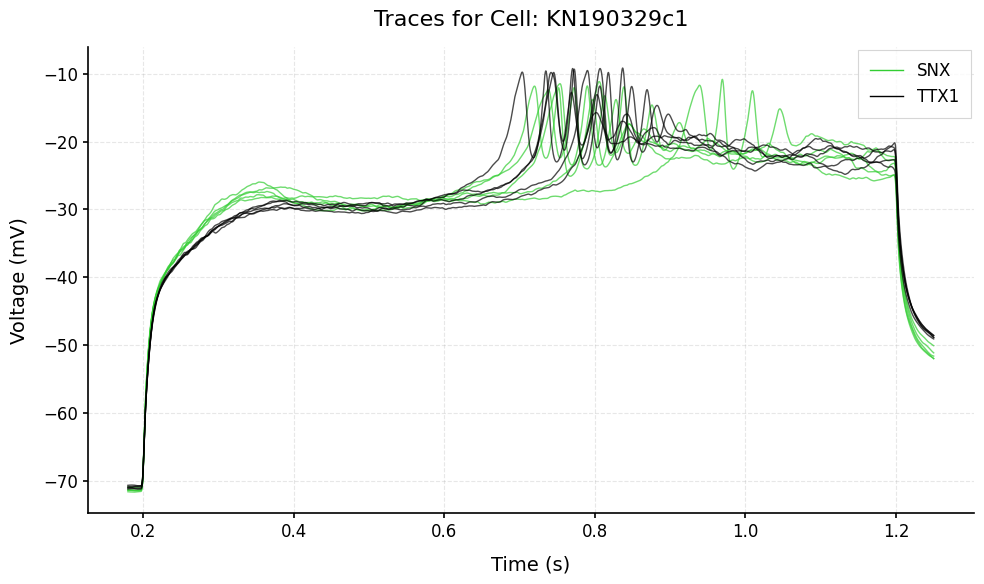

In [15]:
a1 = Cell('KN221212c2', A.path, A.cells_names)
a1 = Cell('KN190329c1', A.path, A.cells_names)
a1.plot_all_traces(save=True)
a1.plot_specific_drug_traces("TTX1", show_spike_region=False, save=False)

In [14]:
# print(f"\nCELL: {a3.cell}")
# print("=" * 60)
#
# for drug, values in a1.parameters_by_condition.items():
#
#     print(f"\n>>> Drug: {drug}")
#     print("-" * 60)
#
#     for key, val in values.items():
#         if isinstance(val, (float, np.floating)):
#             val_str = "nan" if np.isnan(val) else f"{val:.3f}"
#         else:
#             val_str = str(val)
#
#         print(f"{key:<25}: {val_str}")


In [16]:
filenames = [os.path.basename(f) for f in a1.files]
print("files = [")
for name in filenames:
    print(f"    '{name}',")
print("]")

files = [
    'KN190329c1-SNX-V_013_tf_800_007.txt',
    'KN190329c1-SNX-V_013_tf_800_010.txt',
    'KN190329c1-SNX-V_013_tf_800_004.txt',
    'KN190329c1-SNX-V_013_tf_800_009.txt',
    'KN190329c1-SNX-V_013_tf_800_008.txt',
    'KN190329c1-TTX1-V_011_tf_700_018.txt',
    'KN190329c1-TTX1-V_011_tf_700_019.txt',
    'KN190329c1-TTX1-V_011_tf_700_022.txt',
    'KN190329c1-TTX1-V_011_tf_700_021.txt',
    'KN190329c1-TTX1-V_011_tf_700_020.txt',
]
